## Take Home Challenge- User Engagement

The data is available as two attached CSV files:
- takehome_user_engagement. csv
- takehome_users . csv

The data has the following two tables:

1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one of 5 values:
__a__:PERSONAL_PROJECTS: invited to join another user's personal workspace
__b__:GUEST_INVITE: invited to an organization as a guest (limited permissions)
__c__:ORG_INVITE: invited to an organization (as a full member)
__d__:SIGNUP: signed up via the website
__e__:SIGNUP_GOOGLE_AUTH: signed up using Google

Authentication (using a Google email account for their login id)

- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving marketing emails
- enabled_for_marketing_drip: whether they are on the regular marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

2. A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

__Objective:__

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period,  identify which factors predict future user adoption .

In [1]:
## Loading neccessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import Counter

In [2]:
## Loading dataframe-1

df_user_engagement= pd.read_csv('takehome_user_engagement.csv')
df_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
## Loading dataframe-2

df_user= pd.read_csv(r'takehome_users.csv', encoding='latin-1')
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
## Some statistics from both the dataframes

print('No of unique users                      : {}'.format(len(list(df_user_engagement['user_id'].unique()))))
print('No of unique users who signed up        : {}'.format(len(list(df_user['object_id'].unique()))))
print('No of unique users who did not continue : {}'.format(-(len(list(df_user_engagement['user_id'].unique()))- len(list(df_user['object_id'].unique())))))

No of unique users                      : 8823
No of unique users who signed up        : 12000
No of unique users who did not continue : 3177


In [5]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
## fixing the date issues

import time

def fix_last_session_creation_time(row):
    if pd.isna(row['last_session_creation_time']):
        t = pd.to_datetime(row['creation_time'])
        return time.mktime(t.timetuple())
    else:
        return row['last_session_creation_time']

users_clean = df_user
users_clean['last_session_creation_time'] = df_user.apply(fix_last_session_creation_time, axis=1)

In [8]:
def fix_referral(row):
    if pd.isna(row['invited_by_user_id']):
        return 0
    else:
        return row['invited_by_user_id']
    
users_clean['invited_by_user_id'] = df_user.apply(fix_referral, axis=1)

In [9]:
users_clean.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [10]:
# Set index of the date frame for resampler
engagement_index = df_user_engagement.set_index(pd.DatetimeIndex(pd.to_datetime(df_user_engagement.time_stamp).dt.date))
engagement_index


,time_stamp,user_id,visited
time_stamp,,,
2014-04-22,2014-04-22 03:53:30,1,1
2013-11-15,2013-11-15 03:45:04,2,1
2013-11-29,2013-11-29 03:45:04,2,1
2013-12-09,2013-12-09 03:45:04,2,1
2013-12-25,2013-12-25 03:45:04,2,1
...,...,...,...
2013-09-06,2013-09-06 06:14:15,11996,1
2013-01-15,2013-01-15 18:28:37,11997,1
2014-04-27,2014-04-27 12:45:16,11998,1


In [11]:
# Grouping by users and gettong the rolling sum over visited column for a interval of 7 days.
user_frequency = engagement_index.groupby('user_id').resample('D').sum().fillna(0).rolling(window=7, min_periods=0)['visited'].sum()
user_frequency

user_id  time_stamp
1        2014-04-22    1.0
2        2013-11-15    2.0
         2013-11-16    2.0
         2013-11-17    2.0
         2013-11-18    2.0
                      ... 
11996    2013-09-06    4.0
11997    2013-01-15    5.0
11998    2014-04-27    6.0
11999    2012-06-02    7.0
12000    2014-01-26    7.0
Name: visited, Length: 522501, dtype: float64

In [12]:
# Get the maximum value of the rolling sum over all the 7D window
user_frequency_max = user_frequency.reset_index(level='time_stamp').groupby('user_id')['visited'].max().reset_index()

# Add column for yes/no value
user_frequency_max['adopted'] = user_frequency_max.visited > 2

# Merge with user_clean (left join)
users_clean_y = users_clean.merge(user_frequency_max[['user_id', 'adopted']], left_on='object_id', right_on='user_id', how='left').fillna(False)
users_clean_y = users_clean_y.drop('user_id', axis=1)
users_clean_y.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,True
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,True
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,True
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,1.375229e+09,1,1,74,0.0,False
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,1.383604e+09,0,0,302,0.0,False
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,True


In [13]:
# Check whether creation source has many values.
from collections import Counter
Counter(users_clean_y.creation_source)

Counter({'GUEST_INVITE': 2163,
         'ORG_INVITE': 4254,
         'SIGNUP': 2087,
         'PERSONAL_PROJECTS': 2111,
         'SIGNUP_GOOGLE_AUTH': 1385})

In [14]:
categorical = pd.get_dummies(users_clean_y[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']])
categorical.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


In [15]:
from collections import Counter
len(Counter(users_clean_y.org_id))

417

In [16]:
Counter(users_clean_y.org_id).most_common(10)

[(0, 319),
 (1, 233),
 (2, 201),
 (3, 168),
 (4, 159),
 (6, 138),
 (5, 128),
 (9, 124),
 (7, 119),
 (10, 104)]

In [17]:
# Cut org id in 10 bins
counter_org_id = Counter(users_clean_y.org_id)
bins_org_id = dict(zip(
    list(counter_org_id.keys()), 
    pd.cut(list(counter_org_id.values()), bins=10, labels=False).tolist()))

# Apply function to get bin from map
X_org_id_bin = pd.DataFrame({'org_id_bin': users_clean_y.apply(lambda row: bins_org_id[row['org_id']], axis=1)})
X_org_id_bin_enc = pd.get_dummies(X_org_id_bin.org_id_bin, prefix='org_id_bin')
X_org_id_bin_enc.head()

,org_id_bin_0,org_id_bin_1,org_id_bin_2,org_id_bin_3,org_id_bin_4,org_id_bin_5,org_id_bin_6,org_id_bin_7,org_id_bin_9
0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0


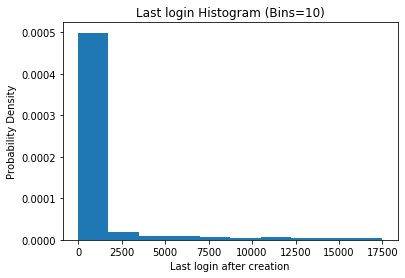

In [18]:

# Get time diff in hours
login_diff = pd.to_datetime(users_clean_y.last_session_creation_time, unit='s') - pd.to_datetime(users_clean_y.creation_time)
login_diff_h = login_diff / pd.Timedelta(hours=1)

# Histogram
_ = plt.hist(login_diff_h.values, density=True, bins=10)
_ = plt.xlabel('Last login after creation')
_ = plt.ylabel('Probability Density')
_ = plt.title('Last login Histogram (Bins=10)')

In [19]:
X_last_login_bin = pd.DataFrame({'last_login_bin': pd.cut(login_diff_h, bins=10, labels=False).tolist()})
X_last_login_bin_enc = pd.get_dummies(X_last_login_bin.last_login_bin, prefix='last_login_bin')
X_last_login_bin_enc.head()

,last_login_bin_0,last_login_bin_1,last_login_bin_2,last_login_bin_3,last_login_bin_4,last_login_bin_5,last_login_bin_6,last_login_bin_7,last_login_bin_8,last_login_bin_9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [20]:
# Merge X
X = pd.concat([categorical, X_org_id_bin_enc, X_last_login_bin_enc], axis=1)
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_bin_0,org_id_bin_1,org_id_bin_2,...,last_login_bin_0,last_login_bin_1,last_login_bin_2,last_login_bin_3,last_login_bin_4,last_login_bin_5,last_login_bin_6,last_login_bin_7,last_login_bin_8,last_login_bin_9
0,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
# Set y
y = users_clean_y['adopted']

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_lr = LogisticRegression()

# Fit the model on the trainng data.
clf_lr.fit(X_train, y_train)

# Print the accuracy from the testing data.
print(accuracy_score(y_test, clf_lr.predict(X_test)))

0.7433333333333333


In [25]:
#the grid of parameters to search over
C= [0.001, 0.1, 1., 10.]

# Hyper-parameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {'C':C}
grid_cv = GridSearchCV(clf_lr, parameters, cv=5, scoring=make_scorer(accuracy_score), iid=True)
grid_cv.fit(X_train, y_train)
print(grid_cv.best_params_, grid_cv.best_score_)
print(round(accuracy_score(grid_cv.predict(X_test), y_test)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

{'C': 0.1} 0.7398809523809524
1.0


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [27]:
best_params = dict(zip(X.columns.tolist(), grid_cv.best_estimator_.coef_[0].tolist()))
best_params_s = sorted(best_params, key=lambda x: abs(best_params[x]), reverse=True)
pd.DataFrame({'feature_name': best_params_s, 'feature_coeff': [best_params[i] for i in best_params_s]}).head(50)

,feature_name,feature_coeff
0,last_login_bin_0,-2.644729
1,creation_source_PERSONAL_PROJECTS,-1.558285
2,creation_source_SIGNUP_GOOGLE_AUTH,1.234333
3,creation_source_SIGNUP,0.685853
4,last_login_bin_2,0.448130
5,last_login_bin_3,0.404341
6,last_login_bin_4,0.325352
7,last_login_bin_6,0.319133
8,last_login_bin_9,0.262389
9,last_login_bin_5,0.251141


__Conclusion:__

One can infer that a user's active the user is on the platform (last login) is the best indicator on user adoption, which is expected as users that have not logged in for a long time are mostly likely the non-active users. In addition, how the user signed up is also a great indicator for prediction. Users signed up using Google Authentication, or via website are most likely to be active on the platform. However, users who signed up for doing Personal Projects, do not end up being active on the platform.